In [1]:
!pip install torchmetrics timm
import gc
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, models, transforms
import torch
from matplotlib import pyplot as plt
from tensorflow import keras
from cv2 import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import torchmetrics 
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.optim import AdamW,Adam # optmizers
import time
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 2.2 MB/s eta 0:00:00


# 데이터

In [2]:
label = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/fixed_labels_v2.csv")
label

,filename,old_label,new_label
0,10.jpg,Type_2,Type_1
1,1001.jpg,Type_2,Type_1
2,1002.jpg,Type_3,Type_2
3,1004.jpg,Type_2,Type_1
4,1005.jpg,Type_3,Type_1
...,...,...,...
1816,975.jpg,Type_2,Type_1
1817,984.jpg,Type_2,Type_3
1818,986.jpg,Type_2,Type_1
1819,988.jpg,Type_2,Type_1


In [3]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [4]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [5]:
bad_files = []
for path in tqdm(files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)

100%|██████████| 8215/8215 [02:10<00:00, 62.74it/s]


In [6]:
bad_files
files_df.drop(bad_files, inplace=True)

In [7]:
# save csv (files_df)
#files_df.to_csv('/kaggle/working/dropfiles.csv', sep=',')

In [8]:
# 정리된 files_df 사용
#files_df = pd.read_csv('../input/dropfiles/dropfiles.csv', sep=',').drop('Unnamed: 0', axis=1)
#files_df

In [9]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,4346
Type 3,2426
Type 1,1440


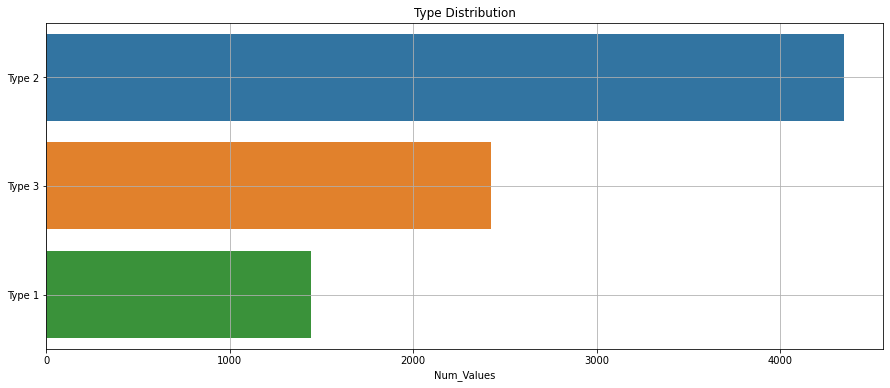

In [10]:
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Type Distribution')
plt.grid(True)
plt.show()

In [11]:
pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Chart of Type Distribution')
fig.show()

# 데이터 분리

In [12]:
# Train / Validation

train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)

print(len(train_df), len(valid_df))

6569 1643


In [13]:
X_train = train_df[['filepath']]
y_train = train_df[['label']]
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [14]:
X_valid = valid_df[['filepath']].reset_index(drop=True)
y_valid = valid_df[['label']].reset_index(drop=True)

print(len(X_train), len(y_train), len(X_valid),len(y_valid))

6569 6569 1643 1643


# 데이터 전처리

In [15]:
# save train data as npy files

#np.save('/kaggle/working/X_train_25', X_train)
#np.save('/kaggle/working/y_train_25', y_train)

In [16]:
features = []
f_app = features.append
path = train_df['filepath'].values
labels = train_df['label'].values
for p in tqdm(path):
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    re_image = cv2.resize(image, (128,128))
    f_app(np.array(re_image))

X_train = np.array(features)
y_train = np.array(labels)

100%|██████████| 6569/6569 [26:00<00:00,  4.21it/s]


In [17]:
# 소요시간줄이는코드 (추가 수정 필요)
#path = train_df['filepath'].values
#labels = train_df['label'].values
#features = [np.array(cv2.resize(cv2.cvtColor(cv2.imread(p),cv2.COLOR_RGB2BGR),(180,180))) for p in tqdm(path)]

In [18]:
# validation data

features = []
f_app = features.append
path = valid_df['filepath'].values
labels = valid_df['label'].values
for p in tqdm(path):
    image = cv2.imread(p)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    re_image = cv2.resize(image, (128,128))
    f_app(np.array(re_image))

X_valid = np.array(features)
y_valid = np.array(labels)

100%|██████████| 1643/1643 [05:55<00:00,  4.62it/s]


In [19]:
# save validation data as npy files

#np.save('/kaggle/working/X_valid', X_valid)
#np.save('/kaggle/working/y_valid', y_valid)

In [20]:
# X train data 확인
X_train[0]

array([[[ 71,  81,  90],
        [ 79,  89,  97],
        [ 88, 101, 106],
        ...,
        [ 87,  57,  81],
        [ 90,  58,  82],
        [ 87,  55,  78]],

       [[ 82,  89,  97],
        [ 88,  95, 101],
        [ 96, 107, 111],
        ...,
        [100,  66,  93],
        [ 99,  65,  92],
        [ 93,  60,  88]],

       [[ 79,  83,  94],
        [ 93,  98, 104],
        [107, 114, 120],
        ...,
        [102,  67, 100],
        [ 99,  64,  96],
        [ 98,  63,  93]],

       ...,

       [[ 94,  62,  86],
        [ 75,  47,  69],
        [ 64,  43,  58],
        ...,
        [ 70,  37,  44],
        [ 69,  37,  48],
        [ 67,  36,  51]],

       [[110,  74, 100],
        [ 89,  57,  81],
        [ 77,  49,  71],
        ...,
        [ 53,  24,  28],
        [ 60,  30,  40],
        [ 65,  36,  54]],

       [[120,  84, 110],
        [108,  75,  99],
        [ 95,  63,  87],
        ...,
        [ 51,  23,  35],
        [ 60,  29,  47],
        [ 78,  46,  72]]

In [21]:
# X validation data 확인
X_valid[0]

array([[[ 59,  51,  72],
        [ 57,  49,  67],
        [ 59,  52,  70],
        ...,
        [ 29,  39,  50],
        [ 22,  31,  39],
        [ 28,  36,  45]],

       [[ 61,  53,  72],
        [ 67,  56,  76],
        [ 68,  54,  77],
        ...,
        [ 22,  40,  48],
        [ 25,  39,  48],
        [ 26,  35,  45]],

       [[ 70,  61,  80],
        [ 67,  59,  73],
        [ 71,  59,  79],
        ...,
        [ 25,  38,  54],
        [ 27,  39,  51],
        [ 28,  37,  47]],

       ...,

       [[ 95,  87, 110],
        [101,  93, 117],
        [115, 103, 127],
        ...,
        [ 63,  49,  74],
        [ 60,  47,  67],
        [ 59,  45,  69]],

       [[ 70,  67,  88],
        [ 85,  78, 101],
        [100,  91, 118],
        ...,
        [ 54,  41,  61],
        [ 54,  41,  58],
        [ 55,  42,  60]],

       [[ 50,  48,  68],
        [ 63,  60,  81],
        [ 76,  67,  93],
        ...,
        [ 53,  40,  63],
        [ 52,  39,  59],
        [ 46,  34,  50]]

In [22]:
# 정규화 (0과1사이의값)
X_train = X_train/255
X_valid = X_valid/255

In [23]:
# 정규화한 X train data 확인
X_train[0]

array([[[0.27843137, 0.31764706, 0.35294118],
        [0.30980392, 0.34901961, 0.38039216],
        [0.34509804, 0.39607843, 0.41568627],
        ...,
        [0.34117647, 0.22352941, 0.31764706],
        [0.35294118, 0.22745098, 0.32156863],
        [0.34117647, 0.21568627, 0.30588235]],

       [[0.32156863, 0.34901961, 0.38039216],
        [0.34509804, 0.37254902, 0.39607843],
        [0.37647059, 0.41960784, 0.43529412],
        ...,
        [0.39215686, 0.25882353, 0.36470588],
        [0.38823529, 0.25490196, 0.36078431],
        [0.36470588, 0.23529412, 0.34509804]],

       [[0.30980392, 0.3254902 , 0.36862745],
        [0.36470588, 0.38431373, 0.40784314],
        [0.41960784, 0.44705882, 0.47058824],
        ...,
        [0.4       , 0.2627451 , 0.39215686],
        [0.38823529, 0.25098039, 0.37647059],
        [0.38431373, 0.24705882, 0.36470588]],

       ...,

       [[0.36862745, 0.24313725, 0.3372549 ],
        [0.29411765, 0.18431373, 0.27058824],
        [0.25098039, 0

In [24]:
# 정규화한 X validation data 확인
X_valid[0]

array([[[0.23137255, 0.2       , 0.28235294],
        [0.22352941, 0.19215686, 0.2627451 ],
        [0.23137255, 0.20392157, 0.2745098 ],
        ...,
        [0.11372549, 0.15294118, 0.19607843],
        [0.08627451, 0.12156863, 0.15294118],
        [0.10980392, 0.14117647, 0.17647059]],

       [[0.23921569, 0.20784314, 0.28235294],
        [0.2627451 , 0.21960784, 0.29803922],
        [0.26666667, 0.21176471, 0.30196078],
        ...,
        [0.08627451, 0.15686275, 0.18823529],
        [0.09803922, 0.15294118, 0.18823529],
        [0.10196078, 0.1372549 , 0.17647059]],

       [[0.2745098 , 0.23921569, 0.31372549],
        [0.2627451 , 0.23137255, 0.28627451],
        [0.27843137, 0.23137255, 0.30980392],
        ...,
        [0.09803922, 0.14901961, 0.21176471],
        [0.10588235, 0.15294118, 0.2       ],
        [0.10980392, 0.14509804, 0.18431373]],

       ...,

       [[0.37254902, 0.34117647, 0.43137255],
        [0.39607843, 0.36470588, 0.45882353],
        [0.45098039, 0

In [25]:
# train 개수, 차원 확인
print(len(X_train), len(y_train))
print(X_train.shape)

6569 6569
(6569, 128, 128, 3)


In [26]:
# validation 개수, 차원 확인
print(len(X_valid), len(y_valid))
print(X_valid.shape)

1643 1643
(1643, 128, 128, 3)


In [27]:
# y 라벨링 (string -> int)
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [28]:
y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [29]:
y_valid_onehot[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [30]:
class Depthwise_bn_relu(tf.keras.Model):
    def __init__(self, strides, padding):
        super(Depthwise_bn_relu, self).__init__()

        self.strides = strides
        self.padding = padding

        self.dw = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), 
                                                  strides=self.strides, 
                                                  padding=self.padding,
                                                  use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        x = self.dw(x)
        x = self.bn(x)
        x = self.relu(x)

        return x



class Pointwise_bn_relu(tf.keras.Model):
    def __init__(self, nb_filters):
        super(Pointwise_bn_relu, self).__init__()

        self.nb_filters = nb_filters

        self.pw = tf.keras.layers.Conv2D(self.nb_filters,
                                         kernel_size=(1, 1), 
                                         strides=(1, 1),  
                                         padding='same', 
                                         use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, training=False):
        x = self.pw(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


    


class MobilenetV1(tf.keras.Model):
    def __init__(self, nb_class):
        super(MobilenetV1, self).__init__()

        self.nb_class = nb_class
        self.zero_pad = tf.keras.layers.ZeroPadding2D((2, 2))
        self.conv = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

        self.block1 = tf.keras.Sequential()
        self.block1.add(Depthwise_bn_relu(1, 'same'))
        self.block1.add(Pointwise_bn_relu(64))
        self.zero_pad_1 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))
        
        
        self.block2 = tf.keras.Sequential()
        self.block2.add(Depthwise_bn_relu(2, 'valid'))
        self.block2.add(Pointwise_bn_relu(128))
        self.block2.add(Depthwise_bn_relu(1, 'same'))
        self.block2.add(Pointwise_bn_relu(128))
        self.zero_pad_2 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))


        self.block3 = tf.keras.Sequential()
        self.block3.add(Depthwise_bn_relu(2, 'valid'))
        self.block3.add(Pointwise_bn_relu(256))
        self.block3.add(Depthwise_bn_relu(1, 'same'))
        self.block3.add(Pointwise_bn_relu(256))
        self.zero_pad_3 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))


        self.block4 = tf.keras.Sequential()
        self.block4.add(Depthwise_bn_relu(2, 'valid'))
        self.block4.add(Pointwise_bn_relu(512))

        for _ in range(5):
            self.block4.add(Depthwise_bn_relu(1, 'same'))
            self.block4.add(Pointwise_bn_relu(512))

        self.zero_pad_4 = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))



        self.block5 = tf.keras.Sequential()
        self.block5.add(Depthwise_bn_relu(2, 'valid'))
        self.block5.add(Pointwise_bn_relu(1024))
        self.block5.add(Depthwise_bn_relu(2, 'same'))
        self.block5.add(Pointwise_bn_relu(1024))


        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.reshape = tf.keras.layers.Reshape((1, 1, 1024))
        self.drop = tf.keras.layers.Dropout(0.001)
        self.conv_pred = tf.keras.layers.Conv2D(1000, 
                                                kernel_size=(1, 1), 
                                                strides=(1, 1), 
                                                padding='same', 
                                                activation='softmax')
        self.reshape_2 = tf.keras.layers.Reshape((1000,))

        


    def call(self, x, training=False):
        x = self.zero_pad(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
       
        x = self.block1(x)
        x = self.zero_pad_1(x)

        x = self.block2(x)
        x = self.zero_pad_2(x)

        x = self.block3(x)
        x = self.zero_pad_3(x)

        x = self.block4(x)
        x = self.zero_pad_4(x)

        x = self.block5(x)

        x = self.gap(x)
        x = self.reshape(x)
        x = self.drop(x)
        x = self.conv_pred(x)
        x = self.reshape_2(x)
        
        return x

    


model = MobilenetV1(1000)
model.build((1, 224, 224, 3))
model.summary()

2022-11-17 17:10:56.354911: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "mobilenet_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  864       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
sequential (Sequential)      (1, 113, 113, 64)         2720      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (1, 56, 56, 128)         

In [31]:
model.compile(
    loss = 'sparse_categorical_crossentropy'
    ,metrics = ['accuracy']
)

In [32]:
BATCH_SIZE = 16
TRAIN_STEPS = len(train_df)//BATCH_SIZE
VAL_STEPS = len(valid_df)//BATCH_SIZE

In [33]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('movilenet_v1', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [34]:
# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

history_mov1 = model.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs = 20
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

2022-11-17 17:11:05.176422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
410/410 [==============================] - 155s 360ms/step - loss: 1.1272 - accuracy: 0.4783 - val_loss: 1.0055 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to movilenet_v1


2022-11-17 17:13:52.679774: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
410/410 [==============================] - 149s 362ms/step - loss: 1.0062 - accuracy: 0.5130 - val_loss: 1.0792 - val_accuracy: 0.5100

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/20
410/410 [==============================] - 146s 355ms/step - loss: 0.9780 - accuracy: 0.5259 - val_loss: 1.4483 - val_accuracy: 0.5295

Epoch 00003: val_accuracy did not improve from 0.52952
Epoch 4/20
410/410 [==============================] - 147s 359ms/step - loss: 0.9641 - accuracy: 0.5201 - val_loss: 1.3225 - val_accuracy: 0.4005

Epoch 00004: val_accuracy did not improve from 0.52952
Epoch 5/20
410/410 [==============================] - 141s 343ms/step - loss: 0.9403 - accuracy: 0.5285 - val_loss: 1.4130 - val_accuracy: 0.3731

Epoch 00005: val_accuracy did not improve from 0.52952
Epoch 6/20
410/410 [==============================] - 144s 352ms/step - loss: 0.9281 - accuracy: 0.5323 - val_loss: 0.9396 - val_accuracy: 0.5563

Epoch 00006: val_accuracy improved from 0.529

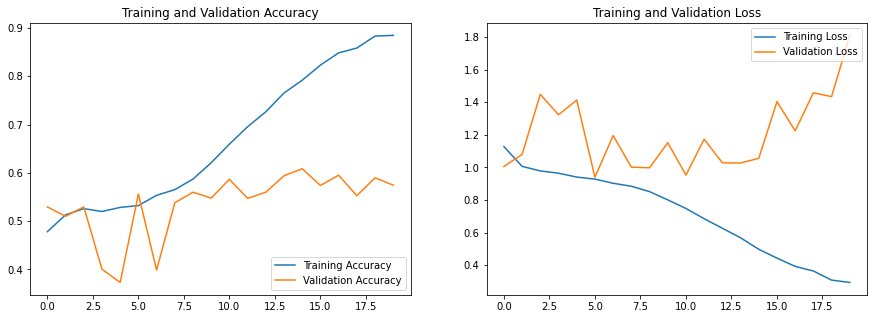

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mov1.history['accuracy'], label='Training Accuracy')
plt.plot(history_mov1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_mov1.history['loss'], label='Training Loss')
plt.plot(history_mov1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [36]:
train_datagen = ImageDataGenerator(rescale=1/255,
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     vertical_flip=True,
                     horizontal_flip=True,
                     fill_mode='nearest')


train_gen_ag = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)

In [37]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('movilenet_v1_ag', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [38]:
history_mov1_ag = model.fit(
    train_gen_ag
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen
    , validation_steps=VAL_STEPS
    , epochs= 20
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/20
410/410 [==============================] - 168s 410ms/step - loss: 0.9815 - accuracy: 0.5274 - val_loss: 11.1158 - val_accuracy: 0.3021

Epoch 00001: val_accuracy improved from -inf to 0.30208, saving model to movilenet_v1_ag
Epoch 2/20
410/410 [==============================] - 169s 411ms/step - loss: 0.9388 - accuracy: 0.5332 - val_loss: 11.3677 - val_accuracy: 0.2947

Epoch 00002: val_accuracy did not improve from 0.30208
Epoch 3/20
410/410 [==============================] - 169s 412ms/step - loss: 0.9259 - accuracy: 0.5292 - val_loss: 7.5752 - val_accuracy: 0.5300

Epoch 00003: val_accuracy improved from 0.30208 to 0.53002, saving model to movilenet_v1_ag
Epoch 4/20
410/410 [==============================] - 168s 410ms/step - loss: 0.9206 - accuracy: 0.5396 - val_loss: 10.6286 - val_accuracy: 0.3297

Epoch 00004: val_accuracy did not improve from 0.53002
Epoch 5/20
410/410 [==============================] - 168s 410ms/step - loss: 0.9149 - accuracy: 0.5420 - val_loss: 7.

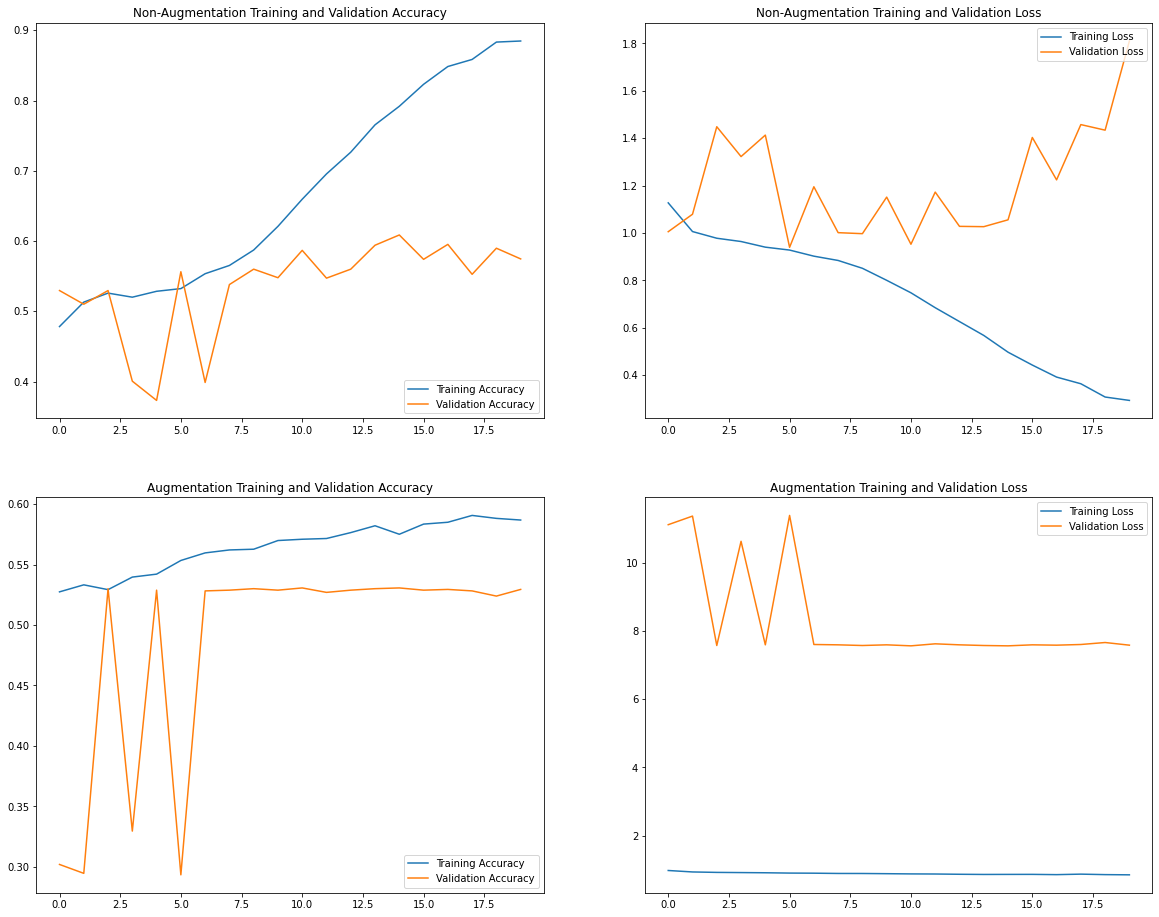

In [39]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_mov1.history['accuracy'], label='Training Accuracy')
plt.plot(history_mov1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_mov1.history['loss'], label='Training Loss')
plt.plot(history_mov1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_mov1_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_mov1_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_mov1_ag.history['loss'], label='Training Loss')
plt.plot(history_mov1_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

In [40]:
#이미지 오류남

#stage1 = y_train[y_train == 0].index
#stage2 = y_train[y_train == 1].index
#stage3 = y_train[y_train == 2].index

#

#stage1 = np.where(y_train == 0)
#type(stage1)
#stageq = stage1[0]

#stage2 = np.where(y_train == 1)
#type(stage2)
#stagew = stage2[0]

#stage3 = np.where(y_train == 2)
#type(stage3)
#stagee = stage3[0]

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('Type1 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stageq[i]])
#    plt.title('Type1')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.show()

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type2 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagew[i]])
#    plt.title('type2')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type2.png', dpi=300)
#plt.show()

#

#plt.figure(figsize=(20, 20))
#
#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type3 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagee[i]])
#    plt.title('type3')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type3.png', dpi=300)
#plt.show()

In [41]:
# 참고용
# double

#history_df_cnn = pd.DataFrame(historycnn.history)
#history_df_dnn = pd.DataFrame(historydnn.history)

#plt.figure(figsize= (15,6))
#plt.subplot(1,2,1)
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
## plt.plot(history_df_cnn['val_accuracy'], label= 'val_accuracy')
#plt.plot(history_df_dnn['accuracy'], label= 'dnn_accuracy', color='limegreen' )
## plt.plot(history_df_dnn['val_accuracy'], label= 'val_accuracy', color='limegreen')
## history_df[['acc', 'val_acc']]
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy History')
#plt.legend()

# display history of loss
#plt.subplot(1,2,2)
#plt.plot(history_df_cnn['loss'], label= 'cnn_loss')
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
#plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
# history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('fig2.png', dpi=300)
#plt.show()


In [42]:
#plt.figure(figsize= (6,6))
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
##plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
## history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('cnnaccuracy.png', dpi=300)
#plt.show()

# test data (2차에 활용)

In [43]:
# test data

#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

#root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
#test_dir = os.path.join(root_dir,'test', 'test')

#test_type = []
#test_features = []
#i=0
#for fn in test_y[['image_name']].to_numpy():
#    for filename in fn:
#        filepath = os.path.join(test_dir,filename)
#        #print(filepath)
#        img = cv2.imread(filepath)
#        resized_img = cv2.resize(img, (180, 180))
#        test_features.append(np.array(resized_img))
#        test_type.append(np.array(test_y.loc[i,['Type_1','Type_2','Type_3']]))
#        i=i+1
    
#print( len(test_features))

In [44]:
#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

In [45]:
#y_test = test_y.loc[:,['Type_1','Type_2','Type_3']]
#y_test
#import tensorflow as tf

In [46]:
#y_train_onehot

In [47]:
#print(y_test)
#list = []
#for d in y_test.index:
#    res = y_test.loc[d,:].values.tolist()
#    list.append(res)

In [48]:
#y_test = np.array(list)
#y_test

In [49]:
# normalize test features
#test_X = np.array(test_features)
#X_test = test_X/255

In [50]:
#print(cnn.evaluate(X_test, y_test))
#print(dnn.evaluate(X_test, y_test))